# AS.030.421 HW 9
## Sam Dawley
## Due: 11/17/2021

Machine learning! It's complicated.

The [Automobile data](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data) provided at that link will allow us to develop a model which takes certain characteristics about cars and try and predict the MPG. Here, we'll compare and contrast two methods of doing so, one which involves traditional statistical regression and the other of which involves machine learning using the `Keras` API. 

Revised:
Consider part 3b. Also, part 5 regarding strengths and weaknesses.

### 1.

We'll start by importing the data and converting it into a `pandas` dataframe for ease of use. Also, the last column is converted to a one-hot.

In [2]:
import pandas as pd
import numpy as np

# Make NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

# URL to extract data from
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

# Names of columns in data set
# Displacement == mileage on car
# Horsepower == how many horses 
column_names = ['MPG', 'Cylinders', 'Displacement', 
                'Horsepower', 'Weight', 'Acceleration', 
                'Model Year', 'Origin']

# Reading the data from the URL above
# Parameters are data set specific
# dtype = 'a' specifies float64 formatting
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', 
                          comment='\t', sep=' ', skipinitialspace=True)

# Converting the elements of the 'Origin' column to something that makes sense,
# that is, '1' changes to 'USA', etc., so that we can see the place of origin
raw_dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, Length: 398, dtype: object

### 2.

Here we simplify our lives, first by cleaning the data and then separating the data into training and testing sets, `x_train` and `y_train`, and `x_test` and `y_test`, respectively. The method for choosing which samples went in which category was completely arbitrary. Ultimately, I tried to place as many possible samples in the training set to allow the model to learn as best it could, while leaving enough samples in the testing set for us to see how well the model actually did. Also, we normalize the data as to avoid accidently weighing certain parameters more than others (I talk about this more later).

In [3]:
from sklearn.preprocessing import StandardScaler

# `cleanData` is all of the data contained in the infile that is not a NaN
# We're effectively 'cleaning' the data
cleanData = raw_dataset.dropna()
cleanDataC = cleanData.copy()

# Now we'll normalize the data using `sklearn`
scaler = StandardScaler().fit(cleanData)
temp_scaled = scaler.transform(cleanData)

# Converting the data back into a pandas dataframe
indices = [i for i in range(7)]
cleanDataC = pd.DataFrame(temp_scaled, columns=column_names)

cleanDataC = cleanData.copy()

In [4]:
# The training data set is chosen arbitrarily as the first 350 rows of the data frame
# Obviously the number of rows / method would have to change for larger data sets
# I managed to find an incredibly convoluted way of identifying all the columns 
# except for the MPG for x_train. Though, it does get the job done.
x_train = cleanDataC.drop(cleanDataC.columns[[0]], axis=1)[:371].to_numpy()
y_train = cleanData.MPG[:371].to_numpy()

# The test data set is what will test the ML model
# cleanData is a pd dataframe and so we can access MPG data directly as a method
x_test = cleanDataC.drop(cleanDataC.columns[[0]], axis=1)[371:].to_numpy()
y_test = cleanData.MPG[371:].to_numpy()

### 3.

Now we develop a mutlivariate linear regression model for predicting MPG given the data we've imported and processed.

A mutlivariate linear regression takes the general form

$$ y = \vec{b}\cdot\vec{x}+c$$

where $y$, the MPG, is our 'feature', or the thing we're trying to estimate, $\vec{x}$ is the vector of 'labels' or data that we've collected to use to estimate the feature, and $c$ is the constant term for the model. $\vec{b}$ represents the coefficients of determination which place weight on each of the labels corresponding to how much they influence the feature. The regression aspect to this fitting finds the vector $\vec{b}$ which most accurately models the data. 

In addition to linear regression, the data was modeled using a *ridge* regression. Ridge regression is a form of penalized regression that deliberatily introduces bias into the model to reduce the variability of the estimate. As a result, the estimates produced by the model generally have a lower mean squared error ([Source](https://www.tandfonline.com/doi/abs/10.1080/00401706.1979.10489815)). Similar to how linear regression seeks to minimize the square of the distance between the line of best fit and the real data (hence "least-squares method"), ridge regression seeks to minimize the expression

$$||y-\vec{b}\cdot\vec{x}||^2 + \alpha||w||^2$$

where the (Euclidean) norm on the left-hand side is the square of the residual just like we're used to, and the extra $\alpha||w||^2$ term corresponds to the artificial bias we introduce ([Source](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)). 

As we'll come to see, the ridge regression for this data is only slightly better, yet still insignificantly better at estimating MPG than the linear regression. This conclusion was found by comparing the mean accuracies of the model, using one of the built-in methods from `sklearn.linear_model`. 

Mean Accuracy of Linear Regression (R^2 value): 0.3319698
Mean Accuracy of Ridge Regression (R^2 value):  0.3319793


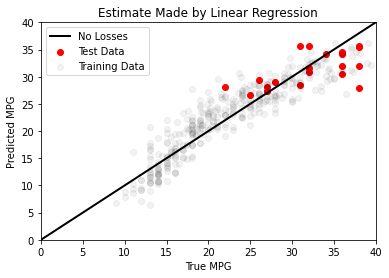

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge


# Plotting the figure and making it look nice
plt.figure()
plt.title('Estimate Made by Linear Regression')
plt.xlabel('True MPG'); plt.ylabel('Predicted MPG')
lims = [0, 40]; plt.xlim(lims); plt.ylim(lims)

# This is the linear regression which will model the data
# Mathematically, this is performing an ordinary least squares method
reg = LinearRegression()
reg.fit(x_train, y_train)
print('Mean Accuracy of Linear Regression (R^2 value): {:0.7f}'.format(reg.score(x_test, y_test)))

# This is the ridge regression which will be compared to the linear regression
regR = Ridge()
regR.fit(x_train, y_train)
print('Mean Accuracy of Ridge Regression (R^2 value):  {:0.7f}'.format(regR.score(x_test, y_test)))

# Results of our model - How well the regression will predict MPG
res = reg.predict(x_test)
resM = reg.predict(x_train)

# Scatter plot of the test data 
# (and the training data to get a sense of how well the model did in general)
plt.scatter(y_test, res, c='r', label='Test Data')
plt.scatter(y_train, resM, c='k', alpha=0.05, label='Training Data')

# This is the line y=x. If our model were perfect, every point on the plot would lie on this line
# Otherwise, there is some error in our regression
plt.plot(lims, lims, c='k', lw=2, label='No Losses')

plt.legend()

### 3b.

We now shift our attention to the goal of modeling the fuel efficiency of a car *not* using a simple linear model. In particular, I've opted to use three different regression models, one of which perform a regression on the data and two of which function to enhance previous regressions (it'll make sense later). In any case, scikit-learn was used for each of the models and all of the documentation that I used and reference in this section can be found at [scikit-learn.org](https://scikit-learn.org/stable/index.html).

The common thread running through each of the models used is that each is an *ensemble method*. Ensemble methods combine predictions of several base estimators built with a given learning algorithm in order to improve generalizibility over a single estimator. Here, I consider both *averaging methods* and *boosting methods*, in the form of random forests and adaptive boosting, respectively, among other things.

The first model used was `sklearn.ensemble.RandomForestRegressor`. *Random forests* are a general class of machine learning model that functions by constructing *decision trees* for each subset of features. A decision tree splits data into smaller groups, allowing the model to draw conclusions about some observation more efficiently. In our case, the decision trees consider, for example, a particular distance the car has traveled ('displacement') and look at other features of the data based on some particular displacement. Another way of looking at it might be that the model classifies the data in terms of patterns, and groups data points with similar patterns together. A *random forest* operates slightly different from a *decision forest* in the sense that it decorrelates trees within the forest by splitting the data on random subsets of features. That is, the model considers only a small subset of features rather than all of the features of the model. The drawbacks of a decision forest are that it tends to overfit and oftentimes exhibit a large variance. The randomness imbued in a random forest remedies these issues.

I learned all about random forests at [Towards Data Science](https://towardsdatascience.com/why-random-forest-is-my-favorite-machine-learning-model-b97651fa3706#:~:text=Random%20forest%20handles%20outliers%20by,indifferent%20to%20non%2Dlinear%20features.&text=It%20has%20methods%20for%20balancing%20error%20in%20class%20population%20unbalanced%20data%20sets.), in a post which explains random forests with much more elegance than I have here. 

The accuracy of the random forest model was measured in the same way as the linear model, plotting the estimated values against the true values. As we can see, this model alone performs much worse than the linear model. Weirdly, there is a noticeable outlier in the test data which I can't for the life of me figure out why it's there. Also, I'll note that the `random_state` was added in all cases for reproducibility. 

Mean Accuracy of Random Forest (R^2 value):  0.1602737


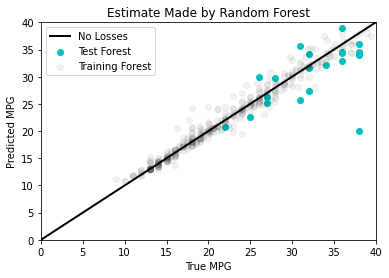

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Plotting the figure and making it look nice
plt.figure()
plt.title('Estimate Made by Random Forest')
plt.xlabel('True MPG'); plt.ylabel('Predicted MPG')
lims = [0, 40]; plt.xlim(lims); plt.ylim(lims)

# Creating the random forest
# `n_estimators` is a hyperparameter than can be optimized. 4 seems to work well
rfr = RandomForestRegressor(n_estimators=4, random_state=314159)

# Fitting the random forest model on the training data
rfr.fit(x_train, y_train)
print('Mean Accuracy of Random Forest (R^2 value):  {:0.7f}'.format(rfr.score(x_test, y_test)))

# Predicting MPG from the test data
rfrTrain = rfr.predict(x_train)
rfrTest = rfr.predict(x_test)

# Scatter plot of the results
plt.scatter(y_test, rfrTest, c='c', label='Test Forest')
plt.scatter(y_train, rfrTrain, c='k', alpha=0.05, label='Training Forest')

# This is the line y=x.
plt.plot(lims, lims, c='k', lw=2, label='No Losses')

plt.legend()

The next model tested was `sklearn.ensemble.AdaBoostRegressor`. *AdaBoost*, short for *adaptive boosting*, is a statistical algorithm which can be used in conjunction with other learning algorithms to improve performance. Here, I use it to boost the random forest model. 

The core principle of AdaBoost is to fit a sequence of 'weak learners' on repeatedly modified versions of the data. The predictions from all of these sequences are combined in a weighted-average to produce the final prediction that we see in the plot. At first, the weights of each prediction are uniform, and with each iteration the sample weights are individually modified and the learning algorithm is reapplied. In particular, the sets which incorrectly predicted the true outcome by the most have their weights increased as to 'boost' their predictive power in the next iteration. Ultimately, the 'weak learner' of the iteration is forced to learn from the mistakes that it made in the previous iteration.

Compared to the random forest on its own, the boosted random forest does score better. 

Mean Accuracy of AdaBoosted Random Tree (R^2 value):  0.1105452


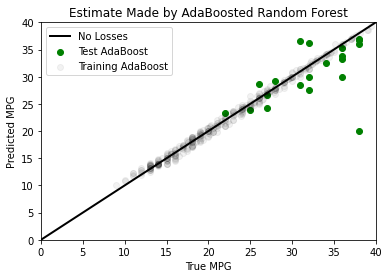

In [7]:
from sklearn.ensemble import AdaBoostRegressor

# Plotting the figure and making it look nice
plt.figure()
plt.title('Estimate Made by AdaBoosted Random Forest')
plt.xlabel('True MPG'); plt.ylabel('Predicted MPG')
lims = [0, 40]; plt.xlim(lims); plt.ylim(lims)

# Initializing AdaBoost using the random forest base estimator
ABT = AdaBoostRegressor(base_estimator=rfr, random_state=314159)

# Fitting the AdaBoosted Forest to the training data
ABT.fit(x_train, y_train)
print('Mean Accuracy of AdaBoosted Random Tree (R^2 value):  {:0.7f}'.format(ABT.score(x_test, y_test)))

# Predicting MPG from the test data
ABTtrain = ABT.predict(x_train)
ABTres = ABT.predict(x_test)

# Scatter plot of the results
plt.scatter(y_test, ABTres, c='g', label='Test AdaBoost')
plt.scatter(y_train, ABTtrain, c='k', alpha=0.05, label='Training AdaBoost')

# This is the line y=x. If our model were perfect, every point on the plot would lie on this line
# Otherwise, there is some error in our regression
plt.plot(lims, lims, c='k', lw=2, label='No Losses')

plt.legend()

At this point, the weird outlier is bugging me enough to where I want to try and remove it from the data set. To start, I printed all of the test data. Looking at each of these entries (and with a little bit of manipulation of the plots above), it became clear how index $10$ was causing some issues with the model.

A few things to notice about this data point. Firstly, the true MPG is much larger compared to the average MPG of the test set, an entire standard deviation from the mean, in fact. Moreover, this MPG is oddly large because the corresponding displacement (distance traveled) of the car is among the largest of the test set, which would normally correlate with a lower fuel efficiency. Lastly, the weight of the car is also among the largest of the test set, another factor that would contribute to a much lower fuel efficiency.

With all of these things in mind, the nature of this point becoming an outlier and disrupting our model makes sense. So, I'll remove and run the AdaBoosted random forest model again.

In [8]:
for i in range(len(y_test)):
    print(y_test[i], x_test[i])
    
x_test_10 = np.delete(x_test, 10, axis=0)
y_test_10 = np.delete(y_test, 10, axis=0)

31.0 [   4.    91.    68.  1970.    17.6   82.     3. ]
38.0 [   4.   105.    63.  2125.    14.7   82.     1. ]
36.0 [   4.    98.    70.  2125.    17.3   82.     1. ]
36.0 [   4.   120.    88.  2160.    14.5   82.     3. ]
36.0 [   4.   107.    75.  2205.    14.5   82.     3. ]
34.0 [   4.   108.    70.  2245.    16.9   82.     3. ]
38.0 [   4.   91.   67. 1965.   15.   82.    3.]
32.0 [   4.    91.    67.  1965.    15.7   82.     3. ]
38.0 [   4.    91.    67.  1995.    16.2   82.     3. ]
25.0 [   6.   181.   110.  2945.    16.4   82.     1. ]
38.0 [   6.  262.   85. 3015.   17.   82.    1.]
26.0 [   4.   156.    92.  2585.    14.5   82.     1. ]
22.0 [   6.   232.   112.  2835.    14.7   82.     1. ]
32.0 [   4.   144.    96.  2665.    13.9   82.     3. ]
36.0 [   4.  135.   84. 2370.   13.   82.    1.]
27.0 [   4.   151.    90.  2950.    17.3   82.     1. ]
27.0 [   4.   140.    86.  2790.    15.6   82.     1. ]
44.0 [   4.    97.    52.  2130.    24.6   82.     2. ]
32.0 [   4.  

Mean Accuracy of AdaBoosted Random Tree (R^2 value):  0.6278441


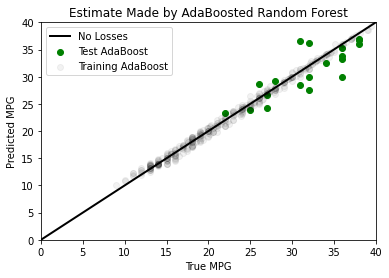

In [9]:
# Plotting the figure and making it look nice
plt.figure()
plt.title('Estimate Made by AdaBoosted Random Forest')
plt.xlabel('True MPG'); plt.ylabel('Predicted MPG')
lims = [0, 40]; plt.xlim(lims); plt.ylim(lims)

# Initializing AdaBoost using the random forest base estimator
ABT = AdaBoostRegressor(base_estimator=rfr, random_state=314159)

# Fitting the AdaBoosted Random forest to the training data
ABT.fit(x_train, y_train)
print('Mean Accuracy of AdaBoosted Random Tree (R^2 value):  {:0.7f}'.format(ABT.score(x_test_10, y_test_10)))

# Predicting MPG from the test data WITHOUT the outlier
ABTtrain = ABT.predict(x_train)
ABTres = ABT.predict(x_test_10)

# Scatter plot of the results
plt.scatter(y_test_10, ABTres, c='g', label='Test AdaBoost')
plt.scatter(y_train, ABTtrain, c='k', alpha=0.05, label='Training AdaBoost')

# This is the line y=x. If our model were perfect, every point on the plot would lie on this line
# Otherwise, there is some error in our regression
plt.plot(lims, lims, c='k', lw=2, label='No Losses')

plt.legend()

Ha! This model is immensely better than the linear model upon removing the outlier.

Last but not least, `sklearn.ensemble.VotingRegressor`: A *voting regression* or *voting ensemble* is a machine learning method which combines the predictions from other ML models and returns a weighted average of the predicted values. Such a regressor works well for sets of equally performing models, ideal for our situation if we consider how each of the random forest and boosted random forest performed above. Such a model *does not work well,* however, when any of the models being voted on outperforms the voting ensemble itself. Luckily, this is not the case for us. 

More helpful and better detailed information can be found at [Machine Learning Mastery](https://machinelearningmastery.com/voting-ensembles-with-python/).

As is clear from the reported score of the voting ensemble, this model does a better job at modeling the data than either of the random forest or boosted random forest alone. Nice!

Mean Accuracy of Voting Regression (R^2 value):  0.7002801


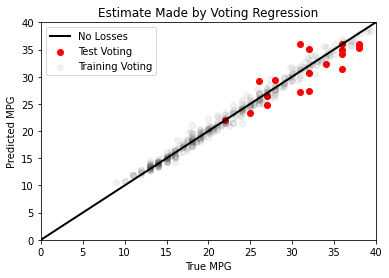

In [10]:
from sklearn.ensemble import VotingRegressor

# Plotting the figure and making it look nice
plt.figure()
plt.title('Estimate Made by Voting Regression')
plt.xlabel('True MPG'); plt.ylabel('Predicted MPG')
lims = [0, 40]; plt.xlim(lims); plt.ylim(lims)

# Fitting the VotingRegressor to the training data
VR = VotingRegressor(estimators=[('rf', rfr), ('abrfr', ABT)], n_jobs=-1).fit(x_train, y_train)
print('Mean Accuracy of Voting Regression (R^2 value):  {:0.7f}'.format(VR.score(x_test_10, y_test_10)))

# Predicting MPG from the test data WITHOUT the outlier
VRtrain = VR.predict(x_train)
VRres = VR.predict(x_test_10)

# Scatter plot of the results
plt.scatter(y_test_10, VRres, c='r', label='Test Voting')
plt.scatter(y_train, VRtrain, c='k', alpha=0.05, label='Training Voting')

# This is the line y=x. If our model were perfect, every point on the plot would lie on this line
# Otherwise, there is some error in our regression
plt.plot(lims, lims, c='k', lw=2, label='No Losses')

plt.legend()

In theory, we could have kept performing different sorts of regression to determine which are optimal and even could have added these to the voting ensemble to chip away at the discrepancy between the true and predicted MPGs for all of the data. Moreover, we could have added the linear regression which was initially created to the voting ensemble to increase our modeling power greatly. Going about this process *ad infinitum* is pointless, though, because this is a homework assignment. 

The other thing to note is that here I've used some machine learning methods instead of purely statistical methods to predict the fuel efficiency. However, isn't machine learning just statistical learning with some more bells and whistles? Based on my limited knowledge and experience, I'd say so :). 

UPDATE: It's tomorrow, I got rid of the outlier. The machine learning methods do a far better job now! The score of the model increased by roughly $4x$. 

### 4.

I don't take credit for any of the machine learning here. In fact, here's where I got the code from:

[Github](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb) and the 
[TensorFlow](https://www.tensorflow.org/tutorials/keras/regression) documentation.

With that out of the way, we can get into the coding part: At this point, we'll approach the problem of estimating MPG using a machine learning model, courtesy of the smart people at MIT (I think). For the most part, I stuck to the reference to the tee, omitting parts which I didn't find immensely helpful.

This example uses the `Keras` API, an interface designed for machine learning.

We'll begin by importing the necessary libraries and data, and reading the data into a usable format.

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Make NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

# First, download and import data using pandas
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

#### Cleaning the data

The data above contains some unknown values which will disrupt the learning process if not taken care of. So, a copy of the original data is made and the unknown values are removed. 

The `'Origin'` column within the data is categorical. Since we're performing a regression, this column is of no use to us unless we convert it to a one-hot. That is, just making the column numerical.

In [12]:
# Make copy of raw data to 
dataset = raw_dataset.copy()

# Here we 'clean' the data, finding and omitting NaNs
dataset.isna().sum()
dataset = dataset.dropna()

# The 'Origin' column is categorical instead of numerical, so we'll change that
# I guess this is sometimes referred to as converting it to a 'one-hot'
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


#### Splitting the data into training and testing sets

Here we split the data into two sets: `train_dataset` contains the samples which will be used for training the model while `test_dataset` contains the sample which will be used for actually testing our model.

Moreover, we'll split the target values from the modeling values, i.e., the 'features' that will be used to estimate the target 'label' are isolated. In the code block below, the features are stored in `train_features` and `test_features`, which is just everything except for the MPG data. `train_labels` and `test_labels` contains the MPG data.

Lastly, some statistics on the data are provided. As is made clear, the range and variance of each parameter are very different from one another. This is our motivation to normalize the data.

In [13]:
# Split dataset into training and testing sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# Examine overall statistics of data
train_dataset.describe().transpose()

# Seperating the target value (MPG) from the features
# `X_features' corresponds to those values which we'll use to estimate the target
# `X_labels` corresponds to the value we're trying to estimate, in this case MPG
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# The range of each piece of data is very different --> Normalization!
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


#### Normalization

In general, it's good practice to normalize data for many different reasons. One reason it's important is because each feature is multiplied by its weight in the model. So, the scale of the outputs are affected by the scale of the inputs. Although it's not *always* necessary, normalization makes training our model much more stable and likely to converge.

In [14]:
# The `preprocessing.Normalization` layer offers a simple way to implement preprocessing
normalizer = preprocessing.Normalization()

# After establishing the layer, we'll adapt it to the data with `adapt()` and
# Then compute the means and variances of each metric, storing the output 
normalizer.adapt(np.array(train_features))

# When the layer is called, it returns the data, properly normalized
# `first` is defined to offer a comparison when we print the data
first = np.array(train_features[:1])

2021-12-01 11:38:35.259744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 11:38:35.290383: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcfe3074890 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-01 11:38:35.290403: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


#### Deep Neural Network Regression (DNN Regression)

The other model provided by the reference uses a linear regression to model the data. I've done so many linear regressions over the course of my life I figured I'd look into something new.

In contrast to the linear model, the DNN regression includes some 'hidden' layers, including a normalization layer, two `Dense` layers with ReLU  activation, and a `Dense` output layer. [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), or *rectified linear activation function*, is a piecewise linear function that outputs an input directly if its postive and outputs zero otherwise. In the context of machine learning, ReLU is effective because it does not suffer from a vanishing gradient like some other activation methods.

The process of building and compiling the model are included in the function `build_and_compile_model`. Then, we'll consider all of the possible inputs to the model, those being the columns from the dataset except for MPG, and train our model on them. 

In contrast to the provided reference, I opted to include a `Dropout` layer in the compiling stage of this model. This technique seeks to address the problem of overfitting that commonly arises during modeling. If all neurons in the model are used every time we compile and try to predict data, inherent reliances neurons have on one another to those which have become specialized to do a certain task introduce bias to the system. 

I'm not even sure what I just wrote makes sense so consider a contrived example: Within our bodies, we have brain cells and we have red blood cells. Brain cells are specialized so much so that erythrocytes will never have to learn how to send electric signals throughout the body and tell other cells what to do. Conversely, brain cells will never have to learn how to carry oxygen throughout our bodies because erythrocytes are so incredibly good at it. Hence, in the tragic event that all of our brain cells stop working there will be no other cells to take their places because everything else in the body relied on their expertise.

The same logic can be applied to a neural network. If we allow each nueron in a machine learning model to specialize in one thing and that neuron becomes biased, no other part of the model will be able to correct it and the neural network loses reliability. 

`Dropout` remedies this complication by "dropping out" a random sample of the neurons from compiling so that each neuron in the model becomes proficient at recognizing and modeling all parts of the data ([Source](https://jmlr.org/papers/v15/srivastava14a.html)).


In [15]:
# The build and compile methods are included in a single function
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# Start DNN model with a all inputs
dnn_model = build_and_compile_model(normalizer)

# Train the model on all parameters
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

#### Plotting the loss

Within machine learning, 'loss' is the penalty for a bad prediction. If a model's prediction was perfect, loss would be zero. Otherwise, the loss is greater than zero and is simply a number indicating how bad the prediction. 

Below we plot the loss to see how our model stacked up against the real data.

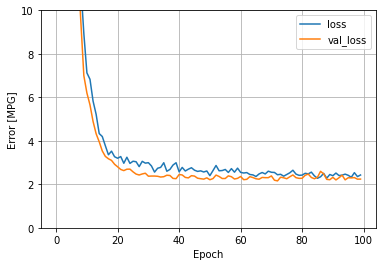

In [16]:
# Function to plot the loss of the model
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    return

plot_loss(history)

#### Making Predictions

We've finally reached the point where we can use our model to make predictions about the target value. The `predict()` method in `keras.Model` class does this for us. The predictions are plotted alongside the real data, revealing that our model didn't do too bad a job. 

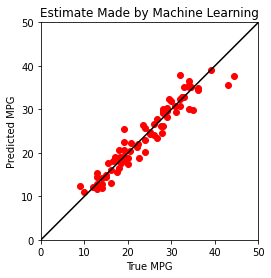

In [17]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, c='r')
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Estimate Made by Machine Learning')
_ = plt.plot(lims, lims, c='k', label='No Loess')

#### Error Distribution

Quantifying the error distribution offers another way of seeing how our model stacked up against the real data.

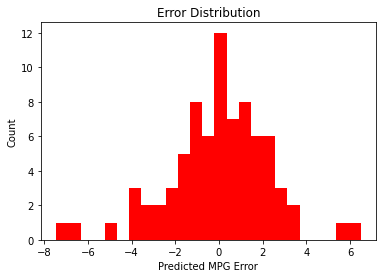

In [18]:
error = test_predictions - test_labels
plt.hist(error, bins=25, color='r')
plt.xlabel('Predicted MPG Error')
plt.title('Error Distribution')
_ = plt.ylabel('Count')

### 5.

Using only the graphs to consider True MPG versus Predicted MPG, clearly the machine learning model does a better job of estimating the label than does our simple regression model. However, I found that the discrepancy between the 'simple' regression and ML model are not as great as I would have initially thought. Because of this, we can compare and contrast their strengths and weaknesses.

##### Strengths of the Regression Model
The linear regression required far less computing, memory, and storage to perform, let alone computer science prowess. Thus, this type of model is well-suited for tasks which do not require an intense amount of accuracy and programming knowledge. Using the data considered here, the rough estimate of MPG provided by the linear regression is certainly good enough for someone who is mildly interested in buying a car.

##### Weaknesses of the Regression Model
As is clear from the graph, the linear regression certainly faulters in the amount of error associated with each data point. For assignments which require precision and accuracy, this model does not do a good job.

##### Strengths of the Random Forest Model
A random forest regression is a very strong statistical model for a plethora of reasons. Not only does it handle the large dimension of data we've provided it in the MPG example above through grouping the data into subsets and categorizing different features,  but also the reduction in deviation from the norm compared to a normal decision tree and other models is incredibly useful. As we saw, random forests (and in particular boosted random forests) do exceptionally well at modeling data, granted no outliers are present. It outperformed the simple linear model by nearly a factor of $2x$, and although the neural network still did a better job at predicting the fuel efficiency, the random forest provided an excellent estimate without requiring nearly as much time or computing power.

##### Weaknesses of the Random Forest Model
The primary weakness of the random forest was that it rarely will ever be perfect (on its own), and reproducibility is difficult to achieve without fixing the `random_state`. In neural networks which go through generations of learning, the randomness associated with the forest would be beneficial, as to avoid bias. In our case, however, this randomness is not helpful. Also, the scaling of a random forest becomes an issue for much larger data sets than what we used here. For samples with data points on the order of $10^5$ or so, the computing power required by a random forest begins to compete with that of other neural networks.

##### Strengths of the Machine Learning Model
All three graphs illustrated in the ML model section portray how accurate this type of modeling can be even for a relatively simple neural network. Moreover, the `Keras` API covers every step of the machine learning process and is easily adaptable to many types of data and situations.

##### Weaknesses of the Machine Learning Model
Using `Keras` suffers from a requirement for much more memory and storage that must be alloted to the system. Also, machine learning is far more time-intensive (both in terms of manual and CPU labor) unlike linear regression which can be understood by someone who is only currently taking a statistics class (me). Lastly, as I mentioned during the compiling stage, machine learning models can suffer from overfitting and introduce (potentially more) bias into a model.

Ultimately, these two models both achieve their task of estimating some feature given a list of parameters and data points. For low-accuracy, fast computations, a linear regression certainly does well enough at modeling the data and illustrating the relationships between parameters. For estimations that require more precision, even a basic machine learning network can be understood and implemented by someone with limited knowledge on the subject and used to model data.